In [3]:
from dataloader.reddit_helper import QueryResult
!pip install -Uq langgraph~=0.1.19
!pip install -Uq pip

In [1]:
from llm.llm_connector import get_mistral_model
from dataloader.reddit_loader import get_top_posts, QueryResult

In [44]:
from extras.constants import final_answer_prompt
from llm.llm_helper import get_final_answer_llm
from pprint import pprint

model = get_mistral_model()
final_answer_model = get_final_answer_llm(final_answer_prompt=final_answer_prompt, model=model)

In [28]:

from llm.llm_helper import FinalAnswer
from typing import Annotated, Sequence, TypedDict


class AgentState(TypedDict):
    final_answer_llm: object
    limit: int
    query: str
    reddit_data: QueryResult
    final_answer: FinalAnswer

# Reddit Node

In [39]:
def reddit_node(agent_state: AgentState):
    print(f"{'='*10} Reddit Node {'='*10}")
    agent_state["reddit_data"]  = get_top_posts(agent_state["query"], agent_state["limit"])
    return {"reddit_data": agent_state["reddit_data"]}

In [16]:
 # reddit_response = reddit_node({"limit": 3, "query": "How to learn python?"})
# pprint(reddit_response)

# LLM Node

In [38]:
def llm_node(agent_state: AgentState):
    print(f"{'='*10} LLM Node {'='*10}")
    model = agent_state["final_answer_llm"]
    query = agent_state["query"]
    reddit_data = agent_state["reddit_data"]
    response = model.invoke({"query": query, "reddit_data": reddit_data})
    agent_state["final_answer"] = response
    return {"final_answer": response}   

In [24]:
# response = llm_node({"final_answer_llm": final_answer_model, "query": "How to learn programming?", "reddit_data": reddit_response})

In [25]:
# pprint(response)

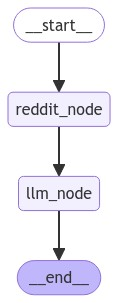

In [40]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)

workflow.add_node("reddit_node", reddit_node)
workflow.add_node("llm_node", llm_node)

workflow.add_edge(START, "reddit_node")
workflow.add_edge("reddit_node", "llm_node")
workflow.add_edge("llm_node", END)


graph = workflow.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Error displaying graph", e)

In [50]:
final_response = graph.invoke({"limit": 5, 
                               "query": "How to build a Chair using red wood?", 
                               "final_answer_llm": final_answer_model})

========== Reddit Node ==========
========== LLM Node ==========


In [52]:
pprint(final_response["final_answer"])

{'answer': 'To build a chair using red wood, you can follow these steps: 1. '
           'Choose a design for your chair. You can find inspiration from '
           'various sources, including the post by CozyBuilds on Reddit '
           '(https://v.redd.it/8jahuabib8671) where they show how to lower '
           'lounge chairs and keep them functional. 2. Gather your materials. '
           'You will need red wood, which is a type of wood known for its '
           'durability and rich color. You can also consider using other types '
           'of wood or materials for certain parts of the chair, as suggested '
           'by GarfieldEnthusiast in a post on Minecraftbuilds '
           '(https://i.redd.it/sbry4cv1xv771). 3. Cut the wood to the '
           'appropriate sizes and shapes for your chair design. You can use a '
           'saw or other tools to do this. 4. Assemble the chair. You can use '
           'nails, screws, or other fasteners to hold the pieces together. '
    